In [19]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.cnns import simple_cnn_bn
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy
from evaluation.metrics import specificity_per_class
from evaluation.metrics import sensitivity_per_class
import os

In [20]:
target_dir = '../../../test_files/EGGIMazing/Dataset'
model_weights_directory = '../../../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cv_cnn_multi_{num_folds}'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [21]:
model_dirs

['../../../logs/cv_cnn_multi_5fold_0_20240817-151002/weights.h5',
 '../../../logs/cv_cnn_multi_5fold_1_20240817-151045/weights.h5',
 '../../../logs/cv_cnn_multi_5fold_2_20240817-151126/weights.h5',
 '../../../logs/cv_cnn_multi_5fold_3_20240817-151207/weights.h5',
 '../../../logs/cv_cnn_multi_5fold_4_20240817-151247/weights.h5']

In [22]:
dp = DatasetProcessor(target_dir)
df = dp.process()

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

split = dp.smarter_multiple_ds_group_k_splits(df_togas,
                                              df_ipo,
                                              k=num_folds,
                                              train_size=0.6,
                                              test_size=0.4,
                                              internal_train_size=0.5,
                                              random_state=42)
metrics = []
for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have
    model = simple_cnn_bn(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal)
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

3/3 [==============================] - 0s 14ms/step


In [23]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics])

/tmp/ipykernel_3444554/382652609.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])


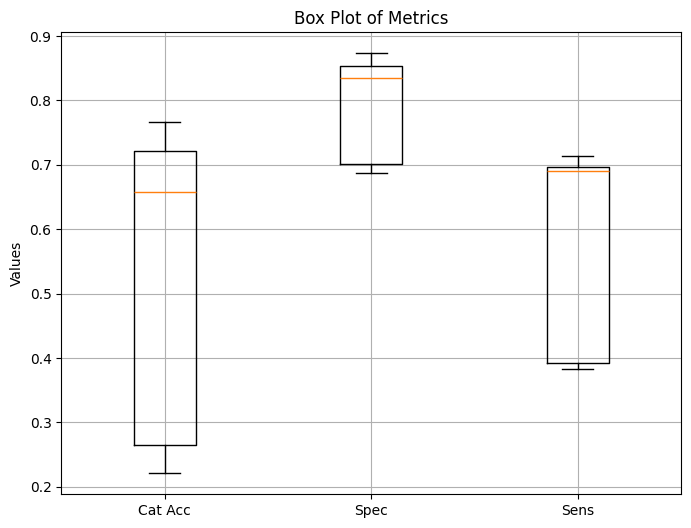

In [24]:
data = [cat_acc, np.mean(spec, axis=1), np.mean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [27]:
print(cat_acc)

[0.65822785 0.22105263 0.76666667 0.26436782 0.72093023]
